### Importing Necessary Dependencies

In [6]:
import pandas as pd
import os
import random
import shutil
import glob
from PIL import Image
from tqdm import tqdm
import numpy as np
import pickle

### Loading and Pre-Processing Data

In [4]:
file_path = "wikiart_full.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

print(df)

                                                filename           artist  \
0      Abstract_Expressionism/aaron-siskind_acolman-1...    aaron siskind   
1      Abstract_Expressionism/aaron-siskind_chicago-6...    aaron siskind   
2      Abstract_Expressionism/aaron-siskind_glouceste...    aaron siskind   
3      Abstract_Expressionism/aaron-siskind_jerome-ar...    aaron siskind   
4      Abstract_Expressionism/aaron-siskind_kentucky-...    aaron siskind   
...                                                  ...              ...   
80037  Impressionism/edgar-degas_portrait-of-mary-cas...      edgar degas   
80038  High_Renaissance/giorgione_portrait-of-a-venet...        giorgione   
80039  High_Renaissance/titian_portrait-of-a-venetian...           titian   
80040  High_Renaissance/pinturicchio_riconciliazione-...     pinturicchio   
80041  High_Renaissance/luca-signorelli_coriolanus-pe...  luca signorelli   

                            genre  \
0      ['Abstract Expressionism']   
1

In [5]:
# Group art by type
all_grouped_art = {}

for index, row in df.iterrows():
    filename = row["filename"]
    art_style = filename[:filename.index('/')]
    
    if art_style not in all_grouped_art:
        all_grouped_art[art_style] = []
    all_grouped_art[art_style].append(row)

for key, value in all_grouped_art.items():
    if len(value) > 2000:
        print(str.ljust(f"Style: {key}", 35),  f"# of Pieces: {len(value)}")

Style: Abstract_Expressionism       # of Pieces: 2594
Style: Art_Nouveau_Modern           # of Pieces: 4168
Style: Baroque                      # of Pieces: 4236
Style: Cubism                       # of Pieces: 2177
Style: Expressionism                # of Pieces: 6335
Style: Impressionism                # of Pieces: 13028
Style: Naive_Art_Primitivism        # of Pieces: 2385
Style: Northern_Renaissance         # of Pieces: 2551
Style: Post_Impressionism           # of Pieces: 6307
Style: Realism                      # of Pieces: 10546
Style: Rococo                       # of Pieces: 2087
Style: Romanticism                  # of Pieces: 6919
Style: Symbolism                    # of Pieces: 4524


In [6]:
# Create dictionary with only art we care about
train_styles = ["Abstract_Expressionism", "Art_Nouveau_Modern", "Cubism", "Impressionism", "Naive_Art_Primitivism"]
grouped_art = {}

for key, value in all_grouped_art.items():
    if key in train_styles:
        grouped_art[key] = value

In [ ]:
# Create directories
for dir in train_styles:
    my_path = f"wikiart_images/{dir}"
    if not os.path.exists(my_path):
        os.mkdir(my_path)

for dir in train_styles:
    my_path = f"train_images/{dir}"
    if not os.path.exists(my_path):
        os.mkdir(my_path)

In [6]:
# Find average image size
total_width, total_height = 0, 0
for art_pieces in grouped_art.values():
    for art_piece in art_pieces:
        total_width += art_piece["width"]
        total_height += art_piece["height"]

print("Total width: ", total_width)
print("Total height: ", total_height)
avg_width_height_ratio = total_width / total_height
print("Average width/height ratio: ", avg_width_height_ratio)

Total width:  40362626
Total height:  39613336
Average width/height ratio:  1.0189150946539822


In [7]:
def getWidthHeightRatio(df_row):
    width = df_row["width"]
    height = df_row["height"]
    return width / height

def withinEpsilon(num1, num2, epsilon):
    return abs(num1 - num2) <= epsilon

def imageNearAverageShape(df_row, ratio, epsilon):
    width_height_ratio = getWidthHeightRatio(df_row)
    return withinEpsilon(width_height_ratio, ratio, epsilon)

In [ ]:
# Find the epsilon and width/height ratio which give us at least 1000 usable images from each style
epsilon = 0.01

found = False
while not found:
    # print("epsilon = ", epsilon)
    ratio = 0.2
    while ratio < 2:
        # print("Ratio = ", ratio)
        counters = []
        for art_style, all_art in grouped_art.items():
            counter = 0
            for art_piece in all_art:
                if imageNearAverageShape(art_piece, ratio, epsilon):
                    counter += 1
            counters.append(counter)
        # print(counters)
        if all(count >= 1000 for count in counters):
            print(f"Images within ratio, epsilon: {ratio}, {epsilon}")
            found = True
        ratio += 0.01
    epsilon += 0.01

# print(counter)

In [10]:
# Save 1000 images from each art style to dictionary
# All images must have a width/height ratio within epsilon of 0.79
ratio = 0.79
epsilon = 0.15

# Save all images which fit proper ratio
train_images = {}
for art_style, all_art_of_style in grouped_art.items():
    art_pieces = all_art_of_style.copy()
    random.shuffle(art_pieces)
    train_images[art_style] = []
    for art_piece in art_pieces:
        if imageNearAverageShape(art_piece, ratio, epsilon):
            train_images[art_style].append(art_piece)

# Reduce # of images to 1000 per each style
for art_style, art_images in train_images.items():
    # train_images[art_style] = train_images[art_style][:1000]
    short_training_images = []
    for art_piece in train_images[art_style]:
        piece_filename = art_piece["filename"]
        wikiart_path = "wikiart_images/" + piece_filename
        if len(short_training_images) == 1000:
            break
        # Some images have weird path names with characters that break the path. This is
        # an easy way of handling that case - simply skipping to the next image
        if os.path.exists(wikiart_path):
            short_training_images.append(art_piece)
    train_images[art_style] = short_training_images

    # print(len(train_images[art_style]))

# print()

In [ ]:
with open('./train_images/train_images_dict.pickle', 'wb') as handle:
    pickle.dump(train_images, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# Move the images from the train dictionary to the train directory

# Clear the train_images directories of any old training images
for style in train_styles:
    files = glob.glob(f"train_images/{style}/*")
    for f in files:
        os.remove(f)

# Move each image from the wikiart_images directory to the train_images directory
for art_style, art_pieces in train_images.items():
    for art_piece in art_pieces:
        piece_filename = art_piece["filename"]
        wikiart_path = "wikiart_images/" + piece_filename
        train_path = "train_images/" + piece_filename
        shutil.copy(wikiart_path, train_path)

In [13]:
def stretchImage(image_path, new_width, new_height):
    # Open the image
    image = Image.open(image_path)
    
    # Resize the image
    stretched_image = image.resize((new_width, new_height))
    
    # Save the stretched image
    stretched_image.save(image_path)

In [14]:
# You can make width and height whatever you want, but recommend width/height ratio = 0.79
width = 100
height = 127

print(f"Compressing or stretching all train images to width = {width}, height = {height}")
print(f"Recommend width/height = {ratio}. Your width/height ratio = {width / height}")

# Compress the images to fit your own width and size
for art_style, art_pieces in train_images.items():
    for art_piece in art_pieces:
        piece_filename = art_piece["filename"]
        train_path = "train_images/" + piece_filename
        stretchImage(train_path, width, height)


Compressing or stretching all train images to width = 100, height = 127
Recommend width/height = 0.79. Your width/height ratio = 0.7874015748031497


### Creating Custom Dataloader for train_images

In [4]:
img_to_style = {}

def hashNPArray(arr):
    return hash(arr.tobytes())

def setImgStyle(img, style):
    img = hashNPArray(img)
    img_to_style[img] = style

def getImgStyle(img):
    img = hashNPArray(img)
    return img_to_style[img]

In [7]:
with open('./train_images/train_images_dict.pickle', 'rb') as handle:
    train_images = pickle.load(handle)

In [8]:
def loadTrainData(batch_size=32, random_order=True, train=True):
    dataset = []
    batch_counter = 0
    batch = []

    train_images_path = "./train_images/"

    train_pieces = []
    for style, art_pieces in train_images.items():
        for piece in art_pieces:
            # print(piece)
            # setImgStyle(piece, style)
            train_pieces.append(piece)
    
    if random_order:
        random.shuffle(train_pieces)

    width = 100
    height = 127

    # for style in train_styles:
    #     style_dir = train_images_path + style + "/"
    #     for file in tqdm(os.listdir(style_dir)):

    for art_piece in tqdm(train_pieces):
        # print(art_piece)  
        img = Image.open(train_images_path + art_piece["filename"])
        img = np.asarray(img).reshape(3, height, width)
        
        filename = art_piece["filename"]
        art_style = filename[:filename.index('/')]

        setImgStyle(img, art_style)

        if batch_counter < batch_size:
            batch.append(img)
            batch_counter += 1
        else:
            dataset.append(np.array(batch))
            batch = []
            batch_counter = 0

    return np.array(dataset)

In [9]:
dataset = loadTrainData(batch_size=32, random_order=False, train=True)

print("Dataset Shape without random order: ", np.shape(dataset))
# print(np.shape(dataset[0][0]))
print("First image should be Abstract Expresisonism, it is: ", getImgStyle(dataset[0][0]))
print("320th image should be Impressionism, it is: ", getImgStyle(dataset[100][0]))

dataset = loadTrainData(batch_size=32, random_order=True, train=True)

print("Dataset Shape with random order: ", np.shape(dataset))
# print(np.shape(dataset[0][0]))
print("First image is: ", getImgStyle(dataset[0][0]))
print("320th image is: ", getImgStyle(dataset[100][0]))

dataset = loadTrainData(batch_size=32, random_order=False, train=True)

100%|██████████| 5000/5000 [00:06<00:00, 753.03it/s] 


Dataset Shape without random order:  (151, 32, 3, 127, 100)
First image should be Abstract Expresisonism, it is:  Abstract_Expressionism
320th image should be Impressionism, it is:  Impressionism


100%|██████████| 5000/5000 [00:02<00:00, 1707.58it/s]


Dataset Shape with random order:  (151, 32, 3, 127, 100)
First image is:  Impressionism
320th image is:  Naive_Art_Primitivism


100%|██████████| 5000/5000 [00:01<00:00, 2663.47it/s]


## Neural Network Implementation

### Importing Necessary Dependencies

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F

### Converting Dataset into Tensor

In [11]:
torch_dataset = torch.from_numpy(dataset)
print("Dataset Shape: ", torch_dataset.shape)

Dataset Shape:  torch.Size([151, 32, 3, 127, 100])


image shape: torch.Size([32, 3, 127, 100])


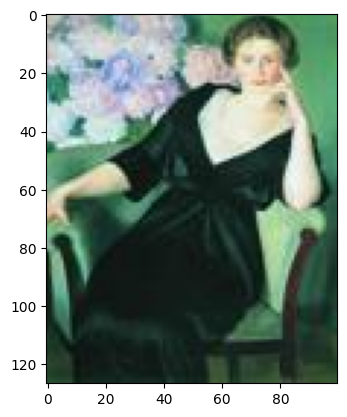

In [12]:
ex_image = torch_dataset[random.randint(0,100)]
print("image shape:", ex_image.shape)

ex_image = ex_image.reshape(-1, 127, 100, 3)
plt.imshow(ex_image[0])

### CNN Architecture

In [13]:
class MyCNN(nn.Module):

    def __init__(self):

        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1)

        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(0.25)

        # Potential for max pooling and dropout layers
        # Ultimately, these would increase architecture depth

        self.linear1 = nn.Linear(64 * 121 * 94, 128)
        self.linear2 = nn.Linear(128, 5)

    def forward(self, features):

        features = features.view(-1, 3, 127, 100).float()

        out = self.conv1(features)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.relu(out)

        out = torch.flatten(out, start_dim=1)

        #out = self.dropout(out)
        out = self.linear1(out)
        out = self.relu(out)
        #out = self.dropout(out)
        out = self.linear2(out)

        out = F.softmax(out, dim=1)

        return out

In [14]:
test_CNN = MyCNN()
test_output = test_CNN(ex_image)

print(test_output.shape)

torch.Size([32, 5])


### Creating Target Labels

In [15]:
def target_labels(dataset):

    num_batches = dataset.shape[0]
    size_batch = dataset.shape[1]
    target_labels_list = []

    for i in range(num_batches):

        batch_target_labels = []

        for j in range(size_batch):
            
            image_style = getImgStyle(dataset[i][j])

            if image_style == "Abstract_Expressionism":
                target_label = [1, 0, 0, 0, 0]
            elif image_style == "Art_Nouveau_Modern":
                target_label = [0, 1, 0, 0, 0]
            elif image_style == "Cubism":
                target_label = [0, 0, 1, 0, 0]
            elif image_style == "Impressionism":
                target_label = [0, 0, 0, 1, 0]
            elif image_style == "Naive_Art_Primitivism":
                target_label = [0, 0, 0, 0, 1]
            
            batch_target_labels.append(target_label)

            if (i == 0) and (j == 0):
                print("Image Style: ", image_style)
                print("Target Label: ", target_label)

        # Stack the target labels for the current batch
        batch_target_labels = torch.tensor(batch_target_labels)
        target_labels_list.append(batch_target_labels)

    print("Target Labels List Shape: ", len(target_labels_list))
    # Stack the target labels for all batches
    target_labels = torch.stack(target_labels_list)

    return target_labels

In [22]:
target_labels_output = target_labels(dataset)
print("Target Labels Shape: ", target_labels_output.shape)
print("First image in dataset should be Abstract Expressionism, it is", getImgStyle(dataset[0][0]))
print("First image should have Abstract Expressionism label, it has: ", target_labels_output[0][0])
print("320th image in dataset should be Impressionism, it is", getImgStyle(dataset[100][0]))
print("320th image should have Impressionism label, it has: ", target_labels_output[100][0])
print("323-image in dataset should be Impressionism, it is", getImgStyle(dataset[100][4]))
print("320-image should have Impressionism label, it has: ", target_labels_output[100][4])
print("Size of each batch in target labels: ", target_labels_output[0].shape)

Image Style:  Abstract_Expressionism
Target Label:  [1, 0, 0, 0, 0]
Target Labels List Shape:  151
Target Labels Shape:  torch.Size([151, 32, 5])
First image in dataset should be Abstract Expressionism, it is Abstract_Expressionism
First image should have Abstract Expressionism label, it has:  tensor([1, 0, 0, 0, 0])
320th image in dataset should be Impressionism, it is Impressionism
320th image should have Impressionism label, it has:  tensor([0, 0, 0, 1, 0])
323-image in dataset should be Impressionism, it is Impressionism
320-image should have Impressionism label, it has:  tensor([0, 0, 0, 1, 0])
Size of each batch in target labels:  torch.Size([32, 5])


### Training of CNN

In [88]:
def cnn_training(model, loss_function, optimizer, train_data, numpy_train_data, n_epochs, update_interval):

    losses = []

    target_labels_output = target_labels(numpy_train_data)

    for epoch in range(n_epochs):

        for i, image in enumerate(train_data):

            optimizer.zero_grad()

            target_output = target_labels_output[i].float()

            model_output = model(image).float()

            loss = loss_function(model_output, target_output)

            loss.backward()

            optimizer.step()

            losses.append(loss.item())

            if i % update_interval == 0:
                print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")

    return model, losses
            

Image Style:  Abstract_Expressionism
Target Label:  [1, 0, 0, 0, 0]
Target Labels List Shape:  151
Epoch: 0, Batch: 0, Loss: 1.8722856044769287
Epoch: 0, Batch: 10, Loss: 0.9048323631286621
Epoch: 0, Batch: 20, Loss: 0.9048323631286621
Epoch: 0, Batch: 30, Loss: 1.592332363128662
Epoch: 0, Batch: 40, Loss: 1.9048326015472412
Epoch: 0, Batch: 50, Loss: 1.9048326015472412
Epoch: 0, Batch: 60, Loss: 1.9048322439193726
Epoch: 0, Batch: 70, Loss: 1.9048326015472412
Epoch: 0, Batch: 80, Loss: 1.9048326015472412
Epoch: 0, Batch: 90, Loss: 1.904832363128662
Epoch: 0, Batch: 100, Loss: 1.9048326015472412
Epoch: 0, Batch: 110, Loss: 1.9048326015472412
Epoch: 0, Batch: 120, Loss: 1.9048326015472412
Epoch: 0, Batch: 130, Loss: 1.9048326015472412
Epoch: 0, Batch: 140, Loss: 1.9048326015472412
Epoch: 0, Batch: 150, Loss: 1.9048326015472412
final Loss 1.9048326015472412


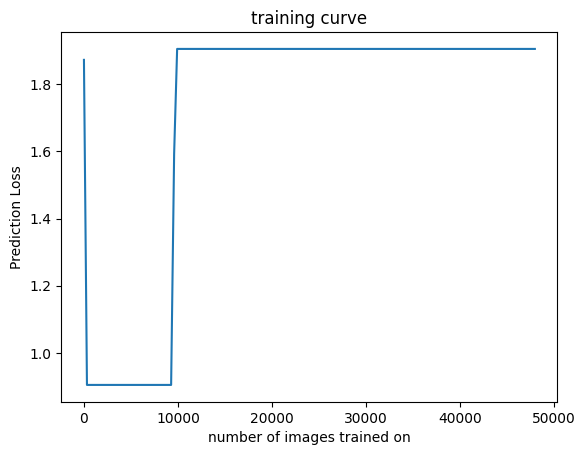

In [90]:
model = MyCNN()
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 1

update_interval = 10

model, losses = cnn_training(model, loss_function, optimizer, torch_dataset, dataset, n_epochs, update_interval)

print("final Loss", losses[-1])

plt.plot(np.arange(len(losses)) * 32 * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("Prediction Loss")
plt.show()